In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [2]:
# read all the words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build a vocabulary of characters and mapping to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g) # embedding matrix that represents each character as a 2 dimensional array
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [20]:
for p in parameters:
    p.requires_grad = True

In [21]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [24]:
lri = []
lossi = []

for i in range(1000):
    
    # mini batches; its faster to have an approximate gradient and take more steps than have an exact one with fewer steps
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append (lre[i])
    lossi.append(loss.item())

print(loss.item())

6.656174182891846
7.408343315124512
6.481301307678223
6.807913780212402
6.7852630615234375
6.4519758224487305
7.231330871582031
6.2535223960876465
6.781736373901367
6.469364643096924
6.815185546875
6.804195404052734
6.602314472198486
7.395977020263672
6.034794807434082
7.601634502410889
6.134557723999023
5.594768047332764
7.0645551681518555
6.78204345703125
6.402271747589111
6.2665863037109375
5.68970251083374
6.546305179595947
6.026890754699707
6.597019672393799
6.30032205581665
6.545235633850098
5.496168613433838
7.287930488586426
6.2288126945495605
5.7601118087768555
6.170979976654053
6.876946926116943
7.555857181549072
6.488043785095215
6.586536407470703
6.371870040893555
6.463231563568115
6.410830497741699
5.484048843383789
7.562224388122559
5.983270645141602
7.17220401763916
6.5202131271362305
5.71602201461792
5.648240089416504
6.2423882484436035
5.869771480560303
5.437829971313477
5.721734046936035
6.212866306304932
7.569277763366699
6.669344902038574
5.517959117889404
5.3833055

3.0159993171691895
3.0483200550079346
3.378044605255127
2.580493211746216
3.187422752380371
2.8779356479644775
2.614687204360962
2.4009017944335938
2.817762613296509
2.8442327976226807
2.8153767585754395
2.6882243156433105
2.7444350719451904
3.490360975265503
3.1128013134002686
3.356593608856201
2.985905170440674
2.85412335395813
2.759033679962158
2.913027763366699
2.857356309890747
3.0194849967956543
2.6129543781280518
2.7229883670806885
2.703918933868408
2.8191819190979004
2.6574783325195312
2.7610342502593994
2.5394327640533447
2.7850229740142822
2.9103450775146484
3.078758955001831
2.838798999786377
3.1036126613616943
2.4694857597351074
2.6189723014831543
2.4205849170684814
3.151676654815674
2.695542335510254
2.419137477874756
3.158790349960327
2.7208611965179443
2.7385923862457275
2.7710225582122803
3.168630838394165
2.486562490463257
2.899965524673462
2.32155704498291
2.7423102855682373
2.5341901779174805
2.978563070297241
2.9919540882110596
2.221785545349121
2.3658242225646973
2

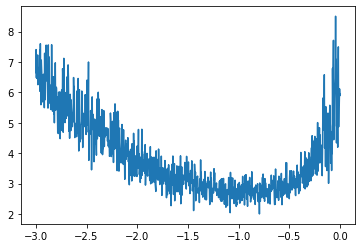

In [25]:
plt.plot(lri, lossi)

### Why PyTorches Cross Entropy function is better than doing it manually

The cross entropy function is way more efficient as it bundles up all the mathematical operations into one kernel and doesnt use any extra memory to create intermediate tensors. The forward and backward pass is also more straightfoward. one other important advantage is that when you take the exp of a number, you can run out of bounds giving inf. Pytorch cross entropy function solves this by negating the highest valued number from the logits as that doesn't change the probability distribution

### Why loss reduces super quick but doesn't go to zero

Another thing, the loss here is super low. This is because we have a lot of parameters and only 32 training examples. The model is unable however to have zero loss as ... input is followed by 4 different letters in all the 4 names so it isn't able to learn that. Right now it is learning all the unique inputs and outputs, thus not generalizing well